# Week 14: CNN Lab - Rock, Paper, Scissors

**Objective:** Build, train, and test a Convolutional Neural Network (CNN) to classify images of hands playing Rock, Paper, or Scissors.

### Step 1: Setup and Data Download

This first cell downloads the dataset from Kaggle.

In [1]:
# Step 1: Setup and Data Download
# (keeps your kagglehub call if available; otherwise falls back to wget/unzip)
try:
    import kagglehub
    path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")
    print("Path to dataset files:", path)
except Exception as e:
    print("kagglehub download not available or failed:", e)
    print("Using fallback: download a public copy and unzip to /content/dataset")
    !rm -rf /content/dataset
    !wget -q -O /tmp/rps.zip "https://storage.googleapis.com/learning-datasets/rock_paper_scissors.zip" || true
    !unzip -q /tmp/rps.zip -d /content || true
    # move extracted folder to consistent path
    if (Path("/content/rockpaperscissors")).exists():
        !rm -rf /content/dataset
        !mv /content/rockpaperscissors /content/dataset
    print("Fallback download complete (if internet allowed).")


Using Colab cache for faster access to the 'rockpaperscissors' dataset.
Path to dataset files: /kaggle/input/rockpaperscissors


In [2]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available: True
GPU name: Tesla T4


### Step 2: Imports and Device Setup

Import the necessary libraries and check if a GPU is available.

In [3]:
# Step 2: Imports and Device Setup
# TODO: Imports and device setup
import os
import random
import numpy as np
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [4]:
!find /root/.cache/kagglehub -maxdepth 5 -type d -iname "rock" -o -iname "paper" -o -iname "scissors"


In [5]:
%%bash
# Copy kagglehub dataset into the expected location
rm -rf /content/dataset
mkdir -p /content/dataset

# adjust path if needed; this is the common kagglehub cache path
SRC="/root/.cache/kagglehub/datasets/drgfreeman/rockpaperscissors/versions/2"

# verify src exists, then copy
if [ -d "$SRC" ]; then
  echo "Copying from: $SRC"
  cp -r "$SRC"/* /content/dataset/
  echo "Copy complete. Listing /content/dataset:"
  ls -la /content/dataset
else
  echo "ERROR: source folder not found at $SRC"
  echo "Please run: find /root/.cache -maxdepth 6 -type d -iname 'rockpaperscissors' -print"
fi

Copying from: /root/.cache/kagglehub/datasets/drgfreeman/rockpaperscissors/versions/2
Copy complete. Listing /content/dataset:
total 120
drwxr-xr-x 6 root root  4096 Nov 19 18:30 .
drwxr-xr-x 1 root root  4096 Nov 19 18:30 ..
drwxr-xr-x 2 root root 36864 Nov 19 18:30 paper
-rw-r--r-- 1 root root   879 Nov 19 18:30 README_rpc-cv-images.txt
drwxr-xr-x 2 root root 28672 Nov 19 18:30 rock
drwxr-xr-x 5 root root  4096 Nov 19 18:30 rps-cv-images
drwxr-xr-x 2 root root 36864 Nov 19 18:30 scissors


### Step 3: Data Loading and Preprocessing

Here we will define our image transformations, load the dataset, split it, and create DataLoaders.

Classes: ['paper', 'rock', 'rps-cv-images', 'scissors']
Total images: 4376
Training images: 3500
Test images: 876


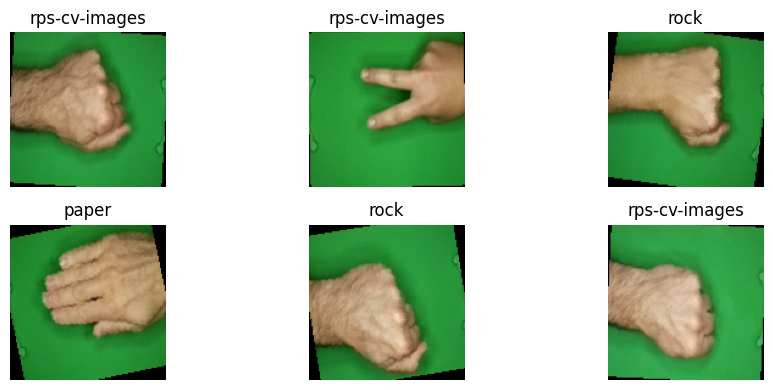

In [6]:
# Step 3: Data Loading and Preprocessing
DATA_DIR = "/content/dataset"

# TODO: Define the image transforms
# We need to:
# 1. Resize all images to 128x128
# 2. Convert them to Tensors
# 3. Normalize them (mean=0.5, std=0.5)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset using ImageFolder
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"{DATA_DIR} not found. Upload dataset or run download cell first.")
full_dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

class_names = full_dataset.classes
print("Classes:", class_names)

# TODO: Split the dataset
# We want 80% for training and 20% for testing
total_len = len(full_dataset)
train_size = int(0.8 * total_len) # 80% of len(full_dataset)
test_size = total_len - train_size  # remaining 20%

# TODO: Use random_split to create train_dataset and test_dataset
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size],
                                          generator=torch.Generator().manual_seed(42))

# TODO: Create the DataLoaders
# Use a batch_size of 32
# Shuffle the training loader, but not the test loader
BATCH_SIZE = 32
# If num_workers causes issues on Colab change to num_workers=0
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Total images: {len(full_dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")

# Show 6 training samples for sanity
def imshow_norm(img_tensor, title=None):
    img = img_tensor.numpy().transpose((1,2,0))
    img = img * 0.5 + 0.5  # denormalize
    img = np.clip(img, 0, 1)
    plt.axis('off')
    if title: plt.title(title)
    plt.imshow(img)

batch = next(iter(train_loader))
imgs, labels = batch
plt.figure(figsize=(10,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    imshow_norm(imgs[i], title=class_names[labels[i]])
plt.tight_layout()


### Step 4: Define the CNN Model

Fill in the `conv_block` and `fc_block` with the correct layers.

In [3]:
# CELL A: Recreate model (Step 4)
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class RPS_CNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*16*16,256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256,num_classes)
        )
    def forward(self,x):
        return self.fc(self.conv_block(x))

# create model with num_classes inferred from dataset (safe)
DATA_DIR = "/content/dataset"
ds = datasets.ImageFolder(DATA_DIR, transform=transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()]))
num_classes = len(ds.classes)
print("Detected classes:", ds.classes, "-> num_classes =", num_classes)

model = RPS_CNN(num_classes=num_classes)
try:
    model = model.to(device)
    print("Model moved to device:", device)
except Exception as e:
    print("Could not move to device, using CPU. Error:", e)
    device = torch.device("cpu")
    model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Print model (short)
print(model)


Using device: cuda
Detected classes: ['paper', 'rock', 'scissors'] -> num_classes = 3
Model moved to device: cuda
RPS_CNN(
  (conv_block): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)


In [4]:
# CELL B: Mini-batch forward+backward test
from torch.utils.data import DataLoader
from torchvision import transforms

test_transform = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor(), transforms.Normalize([0.5]*3,[0.5]*3)])
test_ds = datasets.ImageFolder(DATA_DIR, transform=test_transform)
loader = DataLoader(test_ds, batch_size=4, shuffle=True, num_workers=0)

imgs, labels = next(iter(loader))
imgs, labels = imgs.to(device), labels.to(device)
print("Batch shapes:", imgs.shape, labels.shape, "unique labels:", labels.unique().tolist())

model.train()
optimizer.zero_grad()
outputs = model(imgs)
print("Outputs shape:", outputs.shape)
loss = criterion(outputs, labels)
print("Loss:", loss.item())
loss.backward()
optimizer.step()
print("Mini-batch step completed successfully.")


Batch shapes: torch.Size([4, 3, 128, 128]) torch.Size([4]) unique labels: [1, 2]
Outputs shape: torch.Size([4, 3])
Loss: 1.121809482574463
Mini-batch step completed successfully.


### Step 5: Train the Model

Fill in the core training steps inside the loop.

In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


CUDA available: True
GPU: Tesla T4


In [5]:

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

# re-create transforms and loaders with normalization used earlier
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3,[0.5]*3)
])

full = datasets.ImageFolder(DATA_DIR, transform=transform)
total = len(full)
train_size = int(0.8 * total)
val_size = int(0.1 * total)
test_size = total - train_size - val_size

train_ds, val_ds, test_ds = torch.utils.data.random_split(full, [train_size, val_size, test_size],
                                                          generator=torch.Generator().manual_seed(42))

BATCH_SIZE = 32  # reduce to 16 or 8 if OOM
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

EPOCHS = 10
best_val_acc = 0.0
epoch_losses = []

def validate(model, loader):
    model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct/total if total>0 else 0.0

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0; total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        total += imgs.size(0)
    avg_loss = running_loss / total
    epoch_losses.append(avg_loss)

    val_acc = validate(model, val_loader)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch {epoch}/{EPOCHS}  AvgLoss: {avg_loss:.4f}  Val Acc: {val_acc:.4f}  BestValAcc: {best_val_acc:.4f}")

print("Training finished. Best validation acc:", best_val_acc)
print("Saved model as best_model.pth")


Epoch 1/10  AvgLoss: 1.0560  Val Acc: 0.7064  BestValAcc: 0.7064
Epoch 2/10  AvgLoss: 0.5826  Val Acc: 0.9220  BestValAcc: 0.9220
Epoch 3/10  AvgLoss: 0.2928  Val Acc: 0.9358  BestValAcc: 0.9358
Epoch 4/10  AvgLoss: 0.1764  Val Acc: 0.9725  BestValAcc: 0.9725
Epoch 5/10  AvgLoss: 0.1504  Val Acc: 0.9587  BestValAcc: 0.9725
Epoch 6/10  AvgLoss: 0.1066  Val Acc: 0.9541  BestValAcc: 0.9725
Epoch 7/10  AvgLoss: 0.1077  Val Acc: 0.9587  BestValAcc: 0.9725
Epoch 8/10  AvgLoss: 0.0904  Val Acc: 0.9862  BestValAcc: 0.9862
Epoch 9/10  AvgLoss: 0.0538  Val Acc: 0.9862  BestValAcc: 0.9862
Epoch 10/10  AvgLoss: 0.0522  Val Acc: 0.9862  BestValAcc: 0.9862
Training finished. Best validation acc: 0.9862385321100917
Saved model as best_model.pth


### Step 6: Evaluate the Model

Test the model's accuracy on the unseen test set.

Device used for evaluation: cuda
Detected classes (order): ['paper', 'rock', 'scissors'] num_classes: 3
Loaded model from best_model.pth

Test Accuracy: 97.73%

Confusion Matrix:
 [[83  1  0]
 [ 1 63  0]
 [ 3  0 69]]

Classification Report:
               precision    recall  f1-score   support

       paper       0.95      0.99      0.97        84
        rock       0.98      0.98      0.98        64
    scissors       1.00      0.96      0.98        72

    accuracy                           0.98       220
   macro avg       0.98      0.98      0.98       220
weighted avg       0.98      0.98      0.98       220



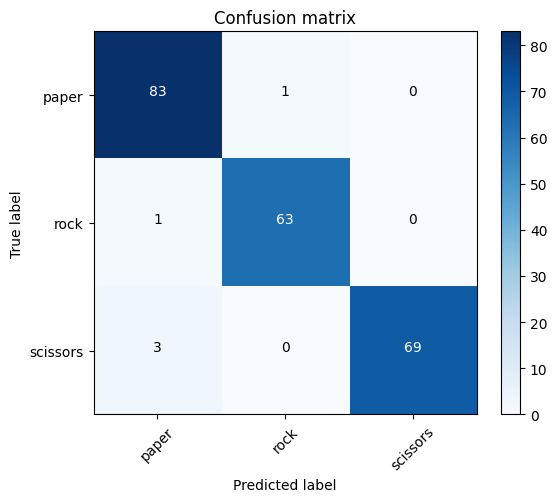

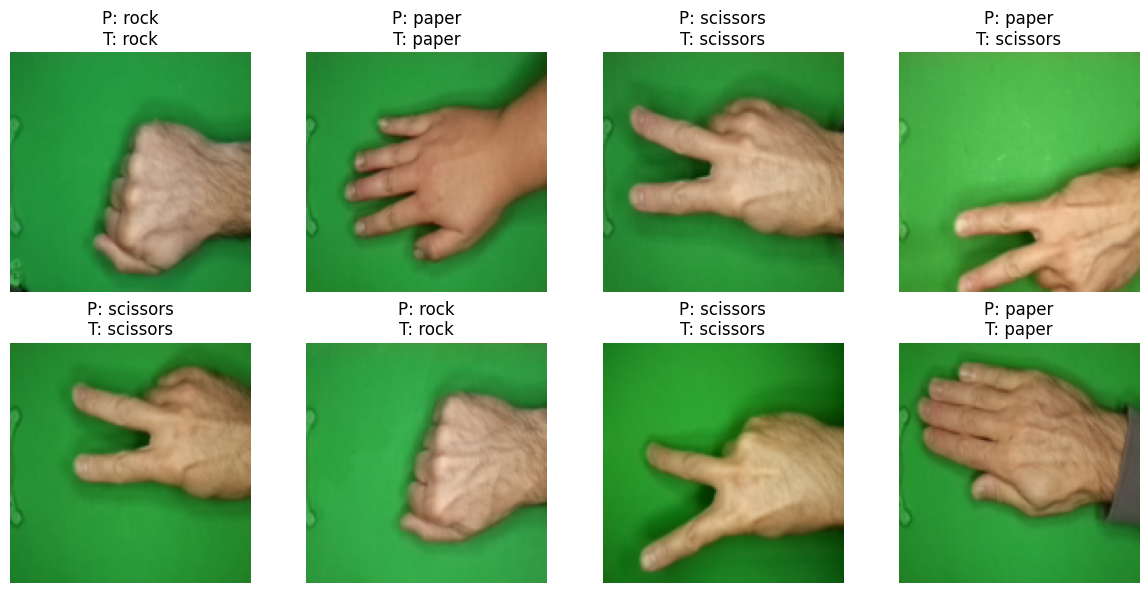


Saved evaluation_summary.txt


In [6]:
# -----------------------------
# STEP 6: Evaluate the Model
# -----------------------------
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import os

# 1) device and dataset paths
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "/content/dataset"
print("Device used for evaluation:", device)

# 2) recreate model architecture exactly like training (safe)
import torch.nn as nn
class RPS_CNN_eval(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*16*16,256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256,num_classes)
        )
    def forward(self,x):
        return self.fc(self.conv_block(x))

# 3) prepare transforms & dataset (must match training transforms for test)
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

full = datasets.ImageFolder(DATA_DIR, transform=test_transform)
classes = full.classes
num_classes = len(classes)
print("Detected classes (order):", classes, "num_classes:", num_classes)

# create test split consistent with training split (we used same seed & splits earlier)
total = len(full)
train_size = int(0.8 * total)
val_size = int(0.1 * total)
test_size = total - train_size - val_size

# Recreate the same random_split partition used during training
from torch.utils.data import random_split
splits = random_split(full, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))
test_ds = splits[2]
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# 4) instantiate model with correct output size and load saved weights
model = RPS_CNN_eval(num_classes=num_classes)
model_path = "best_model.pth"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"{model_path} not found in the notebook working directory. Please ensure you've saved the model after training.")

# load state dict (map to CPU/GPU as appropriate)
state = torch.load(model_path, map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()
print("Loaded model from", model_path)

# 5) Evaluate: gather preds/labels
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
test_acc = (all_preds == all_labels).mean()
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

# 6) Confusion matrix & classification report
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=classes))

# 7) Plot confusion matrix (nice visual)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# annotate cells
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# 8) Show 8 sample test images with predicted vs true labels (random selection)
import random
n_samples = 8
indices = list(range(len(test_ds)))
random.seed(42)
sample_indices = random.sample(indices, min(n_samples, len(indices)))

plt.figure(figsize=(12,6))
for i, idx in enumerate(sample_indices):
    img, label = test_ds[idx]
    # img is normalized tensor — denormalize for display
    img_np = img.numpy().transpose((1,2,0))
    img_np = img_np * 0.5 + 0.5
    pred = classes[ all_preds[idx] ]  # mapping test_ds index -> global test order works because same split
    true = classes[label]
    plt.subplot(2,4,i+1)
    plt.imshow(np.clip(img_np, 0, 1))
    plt.title(f"P: {pred}\nT: {true}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# 9) Save small text summary to disk (useful to screenshot / copy)
with open("evaluation_summary.txt", "w") as f:
    f.write(f"Test Accuracy: {test_acc*100:.2f}%\n\n")
    f.write("Confusion Matrix:\n")
    f.write(np.array2string(cm))
    f.write("\n\nClassification Report:\n")
    f.write(classification_report(all_labels, all_preds, target_names=classes))

print("\nSaved evaluation_summary.txt")


### Step 7: Test on a Single Image

Let's see how the model performs on one image.

In [7]:
# ---------------------------------------
# Step 7: Test on a Single Image
# ---------------------------------------
from PIL import Image

# class_names comes from the dataset
class_names = classes   # already defined in Step 6 or Step 3

# Use the SAME transform as training (normalization must match)
single_img_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

def predict_image(model, img_path):
    model.eval()

    # Load image
    img = Image.open(img_path).convert("RGB")

    # Apply transform and add batch dimension
    img = single_img_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        # 1. Model output logits
        output = model(img)

        # 2. Predicted class index
        _, pred = torch.max(output, dim=1)

    return class_names[pred.item()]

# Test the function
test_img_path = "/content/dataset/paper/0Uomd0HvOB33m47I.png"  # Make sure this exists
prediction = predict_image(model, test_img_path)
print(f"Model prediction for {test_img_path}: {prediction}")


Model prediction for /content/dataset/paper/0Uomd0HvOB33m47I.png: paper


### Step 8: Play the Game!

This code is complete. If your model is trained, you can run this cell to have the model play against itself.

In [8]:
import random
import os

def pick_random_image(class_name):
    folder = f"/content/dataset/{class_name}"
    files = os.listdir(folder)
    img = random.choice(files)
    return os.path.join(folder, img)

def rps_winner(move1, move2):
    if move1 == move2:
        return "Draw"

    rules = {
        "rock": "scissors",
        "paper": "rock",
        "scissors": "paper"
    }

    if rules[move1] == move2:
        return f"Player 1 wins! {move1} beats {move2}"
    else:
        return f"Player 2 wins! {move2} beats {move1}"


# -----------------------------------------------------------
# 1. Choose any two random classes
# -----------------------------------------------------------

choices = ["rock", "paper", "scissors"]
c1 = random.choice(choices)
c2 = random.choice(choices)

img1_path = pick_random_image(c1)
img2_path = pick_random_image(c2)

print("Randomly selected images:")
print("Image 1:", img1_path)
print("Image 2:", img2_path)


# -----------------------------------------------------------
# 2. Predict their labels using the model
# -----------------------------------------------------------

p1 = predict_image(model, img1_path)
p2 = predict_image(model, img2_path)

print("\nPlayer 1 shows:", p1)
print("Player 2 shows:", p2)

# -----------------------------------------------------------
# 3. Decide the winner
# -----------------------------------------------------------

print("\nRESULT:", rps_winner(p1, p2))

Randomly selected images:
Image 1: /content/dataset/scissors/aRca3k5D1oCHVx0h.png
Image 2: /content/dataset/rock/FbQKEoixvDyDPu0c.png

Player 1 shows: scissors
Player 2 shows: rock

RESULT: Player 2 wins! rock beats scissors


Randomly selected images:
Image 1: /content/dataset/scissors/aRca3k5D1oCHVx0h.png
Image 2: /content/dataset/rock/FbQKEoixvDyDPu0c.png

Player 1 shows: scissors
Player 2 shows: rock

RESULT: Player 2 wins! rock beats scissors


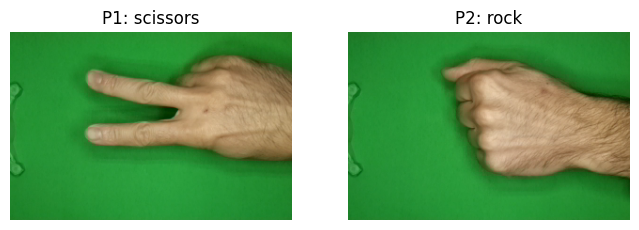

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

# after you compute img1_path, img2_path, p1, p2 and result:
print("Randomly selected images:")
print("Image 1:", img1_path)
print("Image 2:", img2_path)
print("\nPlayer 1 shows:", p1)
print("Player 2 shows:", p2)
print("\nRESULT:", rps_winner(p1, p2))

# display images side-by-side
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].imshow(Image.open(img1_path).convert("RGB"))
axs[0].set_title(f"P1: {p1}")
axs[0].axis('off')
axs[1].imshow(Image.open(img2_path).convert("RGB"))
axs[1].set_title(f"P2: {p2}")
axs[1].axis('off')
plt.show()
